In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import mne
import pathlib
import sklearn
import hdbscan
import seaborn as sns
import statistics
from meegkit import dss

from pycrostates.preprocessing import extract_gfp_peaks
from proof_of_consept import unit_normalize
from neurokit2.microstates.microstates_clean import microstates_clean
from mne_icalabel import label_components
from scipy.stats import kurtosis, skew

In [10]:
def zapline_clean(raw, fline):
    data = raw.get_data().T # Convert mne data to numpy darray
    sfreq = raw.info['sfreq'] # Extract the sampling freq
   
    #Apply MEEGkit toolbox function
    out, _ = dss.dss_line(data, fline, sfreq, nkeep=1) # fline (Line noise freq) = 50 Hz for Europe
    print(out.shape)

    cleaned_raw = mne.io.RawArray(out.T, raw.info) # Convert output to mne RawArray again

    return cleaned_raw

In [11]:
data_folder = pathlib.Path(r"C:\Users\Gulbr\MasterOppgave\epilepsy_data")
file = data_folder / "TLE_0018.bdf"

raw = mne.io.read_raw_bdf(file, verbose=False, preload=False)
raw.crop(tmax=240).load_data()
print(raw.info['ch_names'])
raw.drop_channels(['SO2', 'IO2', 'LO1', 'LO2', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status'])
#Be carefull that artifact electrodes are not included in the average calc.
mne.set_eeg_reference(raw, copy=False, verbose=False)
#Be carefull that artifact electrodes are not included in the average calc.
print(raw.info)
raw.set_montage('biosemi128')
#raw.drop_channels('O2')#raw.info["bads"].append("O2")
#mne.set_eeg_reference(raw, copy=False, verbose=False)
#raw.set_montage('biosemi64')

#bridged, dist = mne.preprocessing.compute_bridged_electrodes(raw)


raw_highpass = raw.copy().filter(l_freq=1, h_freq=None, verbose=False)
raw_lowpass = raw_highpass.copy().filter(l_freq=None, h_freq=100, verbose=False)
line_noise = zapline_clean(raw_lowpass, 50)
raw_down_sampled = line_noise.copy().resample(sfreq=300, verbose=False)

Reading 0 ... 491520  =      0.000 ...   240.000 secs...


['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D16', 'D17', 'D18', 'D19', 'D20', 'D21', 'D22', 'D23', 'D24', 'D25', 'D26', 'D27', 'D28', 'D29', 'D30', 'D31', 'D32', 'SO2', 'IO2', 'LO1', 'LO2', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status']
<Info | 9 non-empty values
 bads: []
 ch_names: A1, A2, A3, A4, A5, A

In [12]:
print(raw_down_sampled.get_data().shape)

(128, 72000)


In [13]:
def gfp_normed_diss_data(indices, data, gfp):
    all_inx = np.arange(data.shape[1])
    unorderd_adj_indices = np.array([indices, (indices-1)]).flatten()
    anti_adj_indices = np.delete(all_inx, unorderd_adj_indices)
    all_inx = np.arange(data.shape[1])
    adj_indices = np.delete(all_inx, anti_adj_indices)

    indexed_data = data[:, adj_indices]
    indexed_gfp = gfp[adj_indices]

    gfp_normed = indexed_data/indexed_gfp


    return gfp_normed

def gfp_normed_diss_data2(indices, data, gfp):
    indexed_data = data[:, indices]
    indexed_gfp = gfp[indices]

    gfp_normed = indexed_data/indexed_gfp


    return gfp_normed

In [14]:
def diss(data, gfp, indices):
    gfp_normed_data = gfp_normed_diss_data(indices, data, gfp)
    diss = np.ndarray(shape=(len(indices), data.shape[0]))
    for t in range(0, len(indices)*2, 2):
        diss[int(t/2), :] = np.square(gfp_normed_data[:, t] - gfp_normed_data[:, t+1])
    return diss

def diss2(data, gfp, indices):
    gfp_normed_data = gfp_normed_diss_data2(indices, data, gfp)
    diss = np.ndarray(shape=(len(indices)-1, data.shape[0]))
    for t in range(1, len(indices)):
        diss[t-1, :] = np.square(gfp_normed_data[:, t] - gfp_normed_data[:, t-1])
    return diss

In [15]:
def epoched_stability1(epochs_object):
    epochs_array = epochs_object.get_data()
    stability = np.ndarray(shape=(epochs_array.shape[0]))
    convex_stabilty = np.ndarray(shape=(epochs_array.shape[0]))
    for e in range(epochs_array.shape[0]):
        data, indices, gfp, info_mne  = microstates_clean(epochs_array[e, :, :], standardize_eeg=False, normalize=False, gfp_method='l2', sampling_rate=epochs_object.info['sfreq'])
        d = diss(data, gfp, indices)
        individual_map_stability = np.sqrt(np.mean(d, 1)) - 1
        for_convex = np.sqrt(np.mean(d, 1))
        stability[e] = np.mean(np.abs(individual_map_stability))
        convex_stabilty[e] = np.mean(for_convex)
    return stability, convex_stabilty

def epoched_stability2(epochs_object):
    epochs_array = epochs_object.get_data()
    stability = np.ndarray(shape=(epochs_array.shape[0]))
    convex_stability = np.ndarray(shape=(epochs_array.shape[0]))
    switching_freq = np.ndarray(shape=(epochs_array.shape[0]))
    significant_switching_freq = np.ndarray(shape=(epochs_array.shape[0]))
    peaks = np.ndarray(shape=(epochs_array.shape[0]))
    for e in range(epochs_array.shape[0]):
        data, indices, gfp, info_mne  = microstates_clean(epochs_array[e, :, :], standardize_eeg=False, normalize=False, gfp_method='l2', sampling_rate=epochs_object.info['sfreq'])
        if e == 0:
            data_at_peaks = data[:, indices]
            full_data = data
        else:
            data_at_peaks = np.concatenate((data_at_peaks, data[:, indices]), axis=1)
            full_data = np.concatenate((full_data, data), axis=1)
        d = diss2(data, gfp, indices)
        individual_map_stability = np.sqrt(np.mean(d, 1)) - 1
        for_convex = np.sqrt(np.mean(d, 1))
        freq = 0
        sfreq = 0
        for s in individual_map_stability:
            if s > 0:
                freq += 1
            if s > 0.4:
                sfreq += 1
        switching_freq[e] = freq
        significant_switching_freq[e] = sfreq
        stability[e] = np.mean(np.abs(individual_map_stability))
        convex_stability[e] = np.mean(for_convex)
        peaks[e] = len(indices)
    return stability, switching_freq, convex_stability, significant_switching_freq, peaks, full_data, data_at_peaks

Bad epoch idenfication - based on topographic stability

Between GFP peaks

In [16]:
ones_epochs = mne.make_fixed_length_epochs(raw_down_sampled, verbose=False, overlap=0.5)

In [17]:
print(ones_epochs.get_data().shape)

Using data from preloaded Raw for 479 events and 300 original time points ...
0 bad epochs dropped
(479, 128, 300)


In [18]:
epoched_stability, epoched_switching_freq, convex_stabilty, significant_switching_freq, peaks, _, _ = epoched_stability2(ones_epochs)

Using data from preloaded Raw for 479 events and 300 original time points ...


Plots to investigate exclusion of epocs not following our assumptions.

Epoch averaged DISS

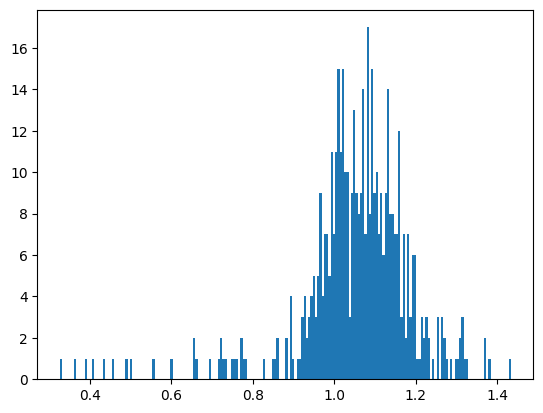

In [19]:
plt.hist(convex_stabilty, bins=200)
plt.show()

In [20]:
timepoints = np.where(convex_stabilty<0)[0]
print((timepoints)/2)

[]


Stability transformed: absoluteDISS = |DISS-1| ... and averaged for each epoch. Now only high values indicate stability.

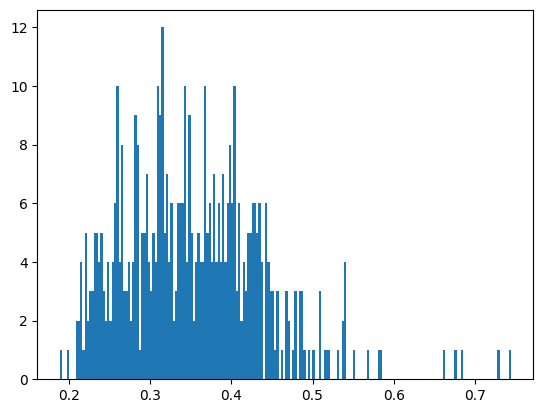

In [21]:
plt.hist(epoched_stability, bins=200)
plt.show()

In [22]:
timepoints = np.where(epoched_stability<0)[0]
print((timepoints)/2)

[]


Average epoch polarity inversion going from gfp peak to gfp peak, meaning DISS < 1.

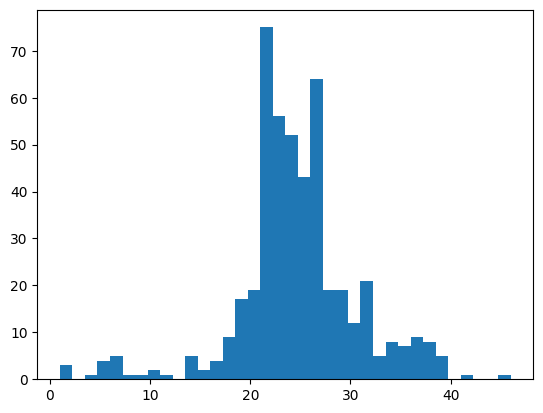

In [23]:
plt.hist(epoched_switching_freq, bins=36)
plt.show()

In [24]:
timepoints = np.where(epoched_switching_freq>300)[0]
print((timepoints)/2)

[]


The same again, but only for shifts in polarity where higher stability is indicated (DISS > 1.4)

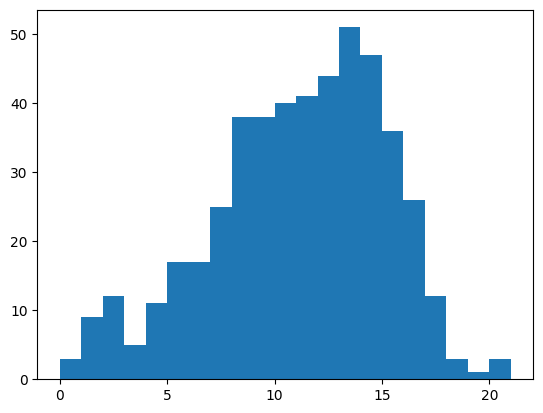

In [25]:
plt.hist(significant_switching_freq, bins=21)
plt.show()

In [26]:
timepoints = np.where(significant_switching_freq==-1)[0]
print((timepoints)/2)

[]


Number of GFP peaks for each epoch

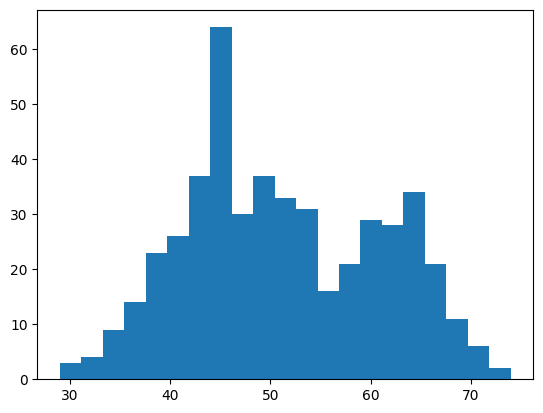

In [27]:
plt.hist(peaks, bins=21)
plt.show()

In [28]:
timepoints = np.where(peaks>500)[0]
print((timepoints)/2)

[]


Looking at scatter plot between swithcing frequencies and number of GFP peaks

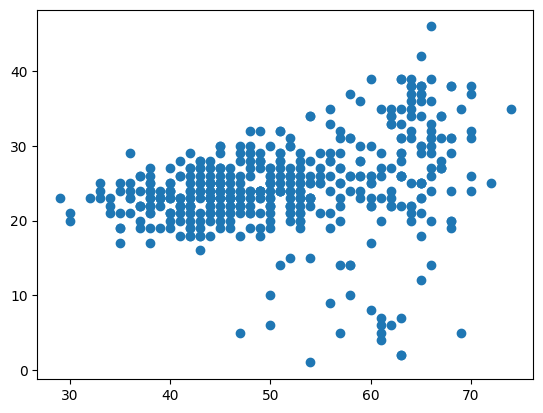

In [29]:
plt.scatter(peaks, epoched_switching_freq)
plt.show()

In [30]:
idx = np.where((epoched_switching_freq < 0))[0]
print((idx-1)/2)

[]


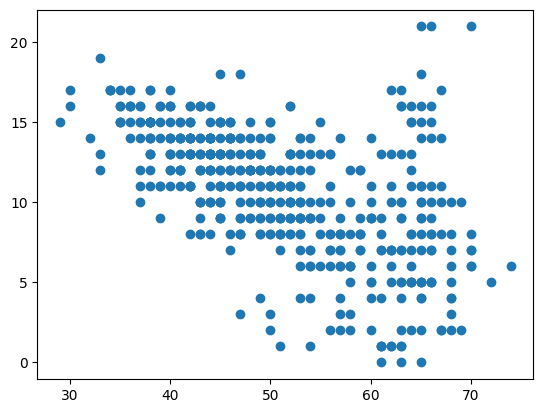

In [31]:
plt.scatter(peaks, significant_switching_freq)
plt.show()

In [32]:
idx = np.where((peaks > 57))[0]
print(idx)
print((idx-1)/2)

idx = np.where((peaks < 28) & (significant_switching_freq < 9))[0]
print((idx-1)/2)

idx = np.where((significant_switching_freq == 0))[0]
print((idx-1)/2)

[  0   1   2   3   6   7   8   9  10  11  12  13  14  15  17  18  19  20
  21  22  23  24  25  26  27  31  32  33  34  35  36  37  38  39  40  41
  42  43  44  45  47  48  49  50  51  52  53  56  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  77  78  79  80  81  82  83
  84  85  86  87  88  89  90  91  93  94  95  96  97  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 128 129 133 134 135 136 139 140 149 150 152 153 154 158
 159 163 172 179 180 181 182 183 184 185 186 187 196 356]
[ -0.5   0.    0.5   1.    2.5   3.    3.5   4.    4.5   5.    5.5   6.
   6.5   7.    8.    8.5   9.    9.5  10.   10.5  11.   11.5  12.   12.5
  13.   15.   15.5  16.   16.5  17.   17.5  18.   18.5  19.   19.5  20.
  20.5  21.   21.5  22.   23.   23.5  24.   24.5  25.   25.5  26.   27.5
  28.5  29.   29.5  30.   30.5  31.   31.5  32.   32.5  33.   33.5  34.
  34.5  35.   35.5  36.   36.5  38.   38.5  39.   39.5  40.   40.5  4

Looking at average absoluteDISS in relation to switching frequencies.

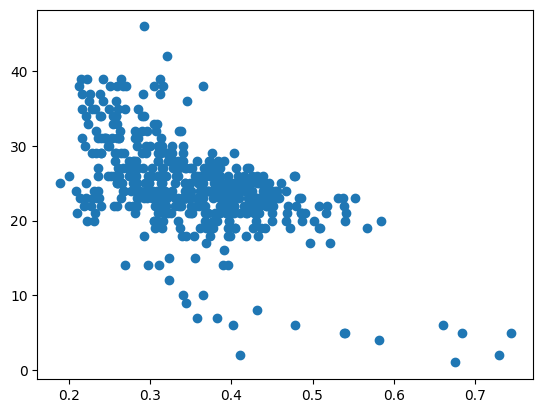

In [33]:
plt.scatter(epoched_stability, epoched_switching_freq)
plt.show()

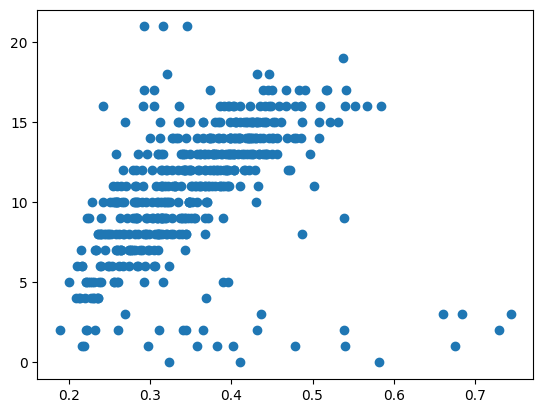

In [34]:
plt.scatter(epoched_stability, significant_switching_freq)
plt.show()

In [35]:
idx = np.where((epoched_stability > 10.5) & (significant_switching_freq < 5))[0]
print((idx-1)/2)

[]


Same but with average DISS

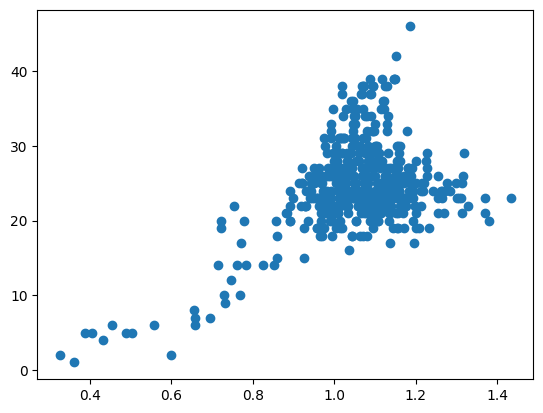

In [36]:
plt.scatter(convex_stabilty, epoched_switching_freq)
plt.show()

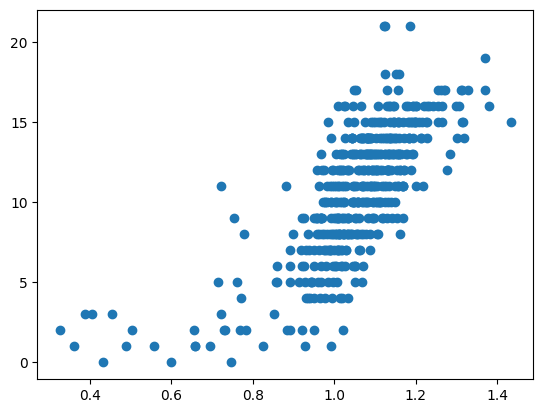

In [37]:
plt.scatter(convex_stabilty, significant_switching_freq)
plt.show()

In [38]:
print(epoched_stability[110*2], convex_stabilty[110*2], epoched_switching_freq[110*2], significant_switching_freq[110*2])

0.40203964761210254 1.2192728214922122 25.0 16.0


In [39]:
print(epoched_stability[int(109.5*2)], convex_stabilty[int(109.5*2)], epoched_switching_freq[int(109.5*2)], significant_switching_freq[int(109.5*2)])

0.4112889800288677 1.1583424315071331 24.0 15.0


In [40]:
print(epoched_stability[int(110.5*2)], convex_stabilty[int(110.5*2)], epoched_switching_freq[int(110.5*2)], significant_switching_freq[int(110.5*2)])

0.3208583111070196 1.1048886752960794 29.0 12.0


Scatter of the two stability types

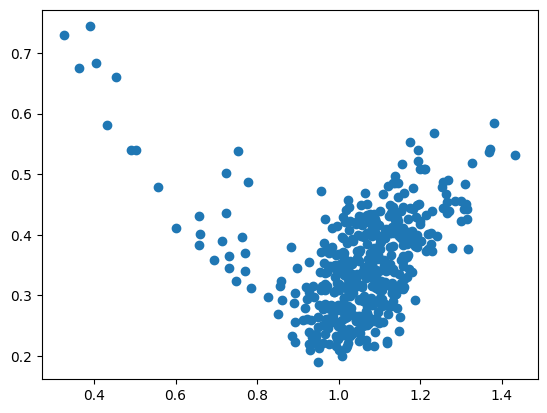

In [41]:
plt.scatter(convex_stabilty, epoched_stability)
plt.show()

In [42]:
idx = np.where((epoched_stability>10.6) & (convex_stabilty<0.75))[0]
print(idx)
print((idx)/2)

[]
[]


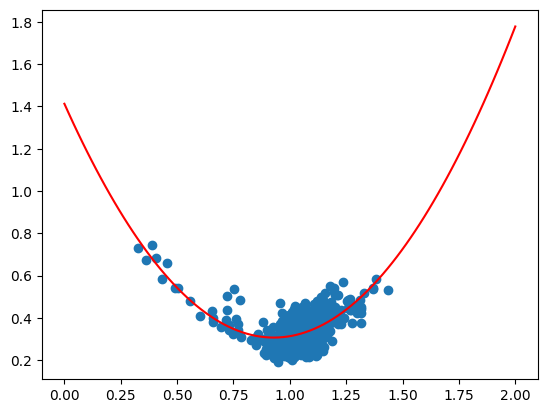

In [43]:
fit = np.poly1d(np.polyfit(convex_stabilty, epoched_stability, 2))
polyline = np.linspace(0, 2, 100)
plt.scatter(convex_stabilty, epoched_stability)
plt.plot(polyline, fit(polyline), color='red')
plt.show()


In [44]:
print(fit)

       2
1.282 x - 2.381 x + 1.413


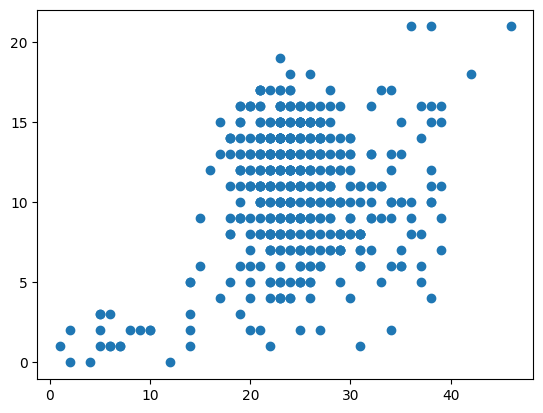

In [45]:
plt.scatter(epoched_switching_freq, significant_switching_freq)
plt.show()

In [46]:
idx = np.where((epoched_switching_freq > 250) & (significant_switching_freq < 15))[0]
print((idx-1)/2)

[]


In [47]:
channel_names = np.array(raw_down_sampled.info['ch_names'])

At GFP peaks

In [48]:
at_epoched_stability, at_convex_stabilty = epoched_stability1(ones_epochs)

Using data from preloaded Raw for 479 events and 300 original time points ...


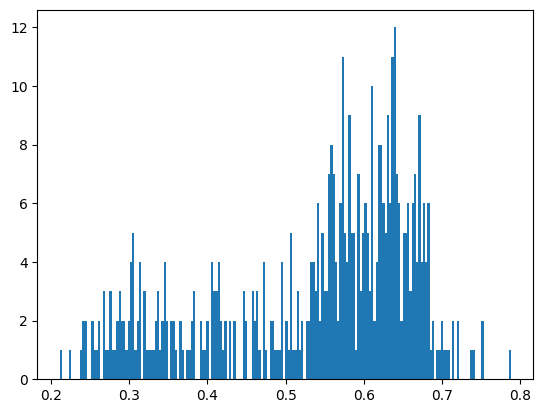

In [49]:
plt.hist(at_epoched_stability, bins=200)
plt.show()

In [50]:
idx = np.where(at_epoched_stability > 10.85)[0]
print((idx-1)/2)
idx = np.where(at_epoched_stability < 0.04)[0]
print((idx-1)/2)

[]
[]


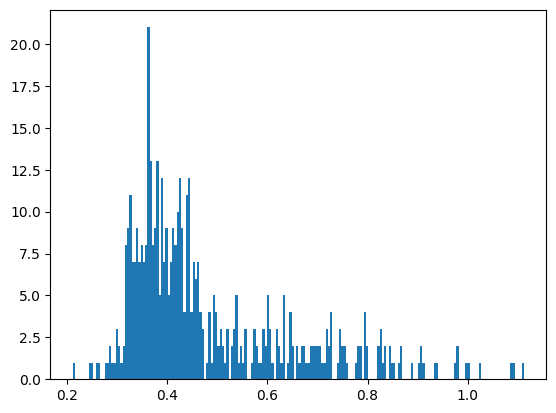

In [51]:
plt.hist(at_convex_stabilty, bins=200)
plt.show()

In [52]:
idx = np.where(at_convex_stabilty > 10.8)[0]
print((idx-1)/2)
idx = np.where(at_convex_stabilty < 0.015)[0]
print((idx-1)/2)

[]
[]


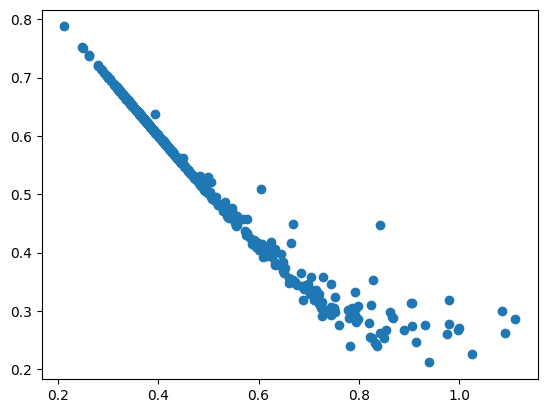

In [53]:
plt.scatter(at_convex_stabilty, at_epoched_stability)
plt.show()

In [54]:
idx = np.where((at_convex_stabilty > 10.8) & (at_epoched_stability < 0.04))[0]
print((idx-1)/2)

[]


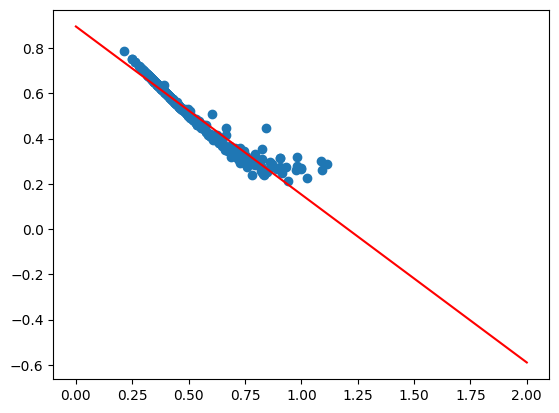

In [55]:
fit = np.poly1d(np.polyfit(at_convex_stabilty, at_epoched_stability, 1))
polyline = np.linspace(0, 2, 100)
plt.scatter(at_convex_stabilty, at_epoched_stability)
plt.plot(polyline, fit(polyline), color='red')
plt.show()

In [56]:
print(fit)

 
-0.7425 x + 0.8954


The median prinsipal for channel stability and pca heuristic analysis

In [57]:
idx = np.where((epoched_stability>=np.median(epoched_stability)) & (convex_stabilty>=np.median(convex_stabilty)) & (at_epoched_stability > np.median(at_epoched_stability)))[0]
print(idx)

[161 176 198 199 200 201 202 205 213 214 216 217 218 219 220 228 229 231
 232 237 238 239 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259 260 261 262 263 264 265 272 278 279 280 281 282 283 284 285 289
 290 291 293 298 299 300 301 302 303 304 305 306 307 308 311 314 318 319
 323 325 328 329 330 331 334 346 347 348 349 350 351 358 359 372 374 375
 378 379 381 382 383 384 385 386 387 388 389 390 396 397 398 401 402 403
 404 405 406 407 408 409 413 414 415 416 417 425 426 427 430 431 432 439
 440 441 444 445 446 451 452 453 454 461 462 463 464 468 469 470 473 474
 475]


In [58]:
print(channel_names)

['A1' 'A2' 'A3' 'A4' 'A5' 'A6' 'A7' 'A8' 'A9' 'A10' 'A11' 'A12' 'A13'
 'A14' 'A15' 'A16' 'A17' 'A18' 'A19' 'A20' 'A21' 'A22' 'A23' 'A24' 'A25'
 'A26' 'A27' 'A28' 'A29' 'A30' 'A31' 'A32' 'B1' 'B2' 'B3' 'B4' 'B5' 'B6'
 'B7' 'B8' 'B9' 'B10' 'B11' 'B12' 'B13' 'B14' 'B15' 'B16' 'B17' 'B18'
 'B19' 'B20' 'B21' 'B22' 'B23' 'B24' 'B25' 'B26' 'B27' 'B28' 'B29' 'B30'
 'B31' 'B32' 'C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8' 'C9' 'C10' 'C11'
 'C12' 'C13' 'C14' 'C15' 'C16' 'C17' 'C18' 'C19' 'C20' 'C21' 'C22' 'C23'
 'C24' 'C25' 'C26' 'C27' 'C28' 'C29' 'C30' 'C31' 'C32' 'D1' 'D2' 'D3' 'D4'
 'D5' 'D6' 'D7' 'D8' 'D9' 'D10' 'D11' 'D12' 'D13' 'D14' 'D15' 'D16' 'D17'
 'D18' 'D19' 'D20' 'D21' 'D22' 'D23' 'D24' 'D25' 'D26' 'D27' 'D28' 'D29'
 'D30' 'D31' 'D32']


In [59]:
channelstab_epochs = mne.make_fixed_length_epochs(raw_down_sampled, verbose=False, preload=True, duration=0.5)

In [60]:
anti_idx = np.arange(480)
anti_idx = np.delete(anti_idx, idx)
print(anti_idx)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 203 204
 206 207 208 209 210 211 212 215 221 222 223 224 225 226 227 230 233 234
 235 236 240 241 242 243 266 267 268 269 270 271 273 274 275 276 277 286
 287 288 292 294 295 296 297 309 310 312 313 315 31

In [61]:
#channelstab_epochs.drop(anti_idx)

In [62]:
def remove_bad(mne_epoch_object, channel_name):
    raw = mne_epoch_object.copy()
    raw.drop_channels(channel_name)
    return raw

In [63]:
def leav_one_out(epochs_object):
    epoched_stability, _, _, _, _, _, _ = epoched_stability2(epochs_object)
    ch_name_list = epochs_object.info['ch_names']
    basline_stability = np.mean(epoched_stability)
    stability_change = np.ndarray(shape=(len(ch_name_list)))
    for c in range(len(ch_name_list)):
        instance = remove_bad(epochs_object, ch_name_list[c])
        stab, _, _, _, _, _, _ = epoched_stability2(instance)
        stability_change[c] = basline_stability - np.mean(stab)        
    return stability_change

In [7]:
def leav_one_out2(epochs_object):
    epoched_stability, _ = epoched_stability1(epochs_object)
    ch_name_list = epochs_object.info['ch_names']
    basline_stability = np.mean(epoched_stability)
    stability_change = np.ndarray(shape=(len(ch_name_list)))
    for c in range(len(ch_name_list)):
        instance = remove_bad(epochs_object, ch_name_list[c])
        stab, _ = epoched_stability1(instance)
        stability_change[c] = basline_stability - np.mean(stab)        
    return stability_change

In [64]:
#channelstab_epochs = mne.make_fixed_length_epochs(raw_down_sampled, verbose=False, preload=True, duration=0.5)
at_test1 = leav_one_out2(channelstab_epochs)
#channelstab_epochs.drop([100, 101, 102, 108, 109, 110, 111])
test1 = leav_one_out(channelstab_epochs)

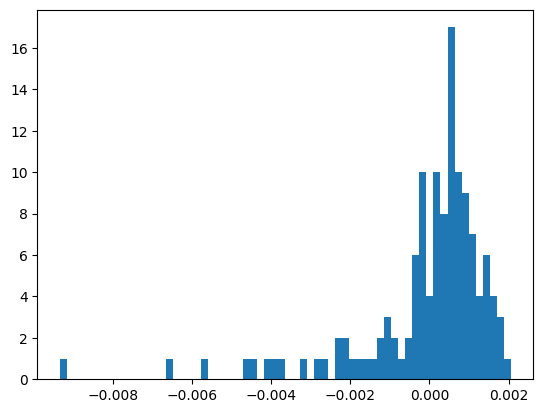

In [65]:
plt.hist(at_test1, bins=64)
plt.show()

In [66]:
order = np.argsort(at_test1)
print(channel_names[order])

['B26' 'B14' 'D24' 'D23' 'B16' 'B25' 'B15' 'B24' 'C28' 'D25' 'B23' 'B27'
 'C29' 'B17' 'B29' 'B12' 'B22' 'B13' 'D22' 'B10' 'C32' 'B11' 'C27' 'D4'
 'D8' 'B28' 'C26' 'C17' 'D5' 'D9' 'D30' 'B18' 'B30' 'B31' 'B4' 'D3' 'D10'
 'D29' 'D21' 'D26' 'D11' 'B5' 'B19' 'D19' 'D13' 'C18' 'C10' 'D12' 'B21'
 'B2' 'D27' 'C31' 'B3' 'C4' 'D6' 'C19' 'C25' 'C21' 'D28' 'D18' 'B20' 'A2'
 'C24' 'B32' 'B1' 'D2' 'C3' 'A1' 'C6' 'A3' 'D20' 'C23' 'C5' 'C20' 'D16'
 'C7' 'D17' 'B6' 'A9' 'C2' 'B7' 'C9' 'C22' 'D31' 'C11' 'A32' 'A8' 'A7'
 'A4' 'C13' 'A31' 'D14' 'C16' 'D7' 'A6' 'C12' 'D1' 'C14' 'A30' 'A18' 'A20'
 'C15' 'C8' 'B8' 'A5' 'A19' 'A26' 'D32' 'A25' 'C1' 'B9' 'A17' 'A24' 'A28'
 'A29' 'C30' 'A21' 'A23' 'A13' 'A27' 'A12' 'A16' 'D15' 'A22' 'A14' 'A10'
 'A15' 'A11']


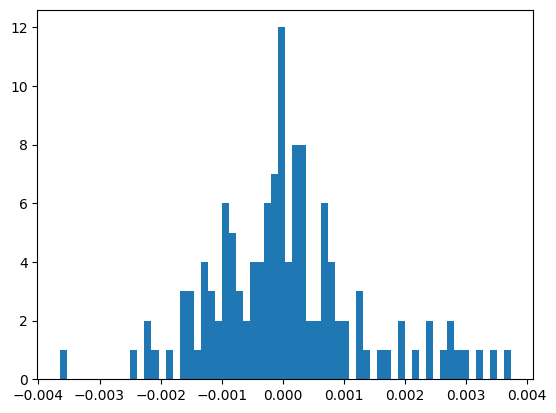

In [67]:
plt.hist(test1, bins=64)
plt.show()

In [68]:
order = np.argsort(test1)
print(channel_names[order])

['B26' 'C29' 'B27' 'B15' 'B14' 'B24' 'B12' 'C7' 'D24' 'B16' 'C28' 'B29'
 'B28' 'D20' 'D23' 'B13' 'D22' 'C17' 'D8' 'C27' 'B25' 'D19' 'D9' 'C32'
 'D6' 'C30' 'D4' 'D11' 'D15' 'D10' 'C31' 'D21' 'B23' 'D1' 'D5' 'C8' 'B17'
 'D25' 'D7' 'B10' 'D26' 'C1' 'C12' 'A19' 'C9' 'D28' 'C6' 'B5' 'C5' 'B18'
 'C26' 'B4' 'B2' 'D13' 'A3' 'B11' 'C4' 'C25' 'C20' 'C10' 'B31' 'A2' 'A8'
 'B19' 'A4' 'D17' 'A5' 'B22' 'D27' 'D12' 'A1' 'C18' 'D29' 'B30' 'A6' 'C21'
 'C23' 'A20' 'C19' 'B6' 'D3' 'A32' 'C15' 'D18' 'B21' 'D14' 'B3' 'B20' 'A7'
 'B1' 'D2' 'C16' 'A18' 'C3' 'B32' 'D16' 'C14' 'B7' 'A9' 'C13' 'D30' 'C22'
 'A30' 'B9' 'C11' 'C24' 'A21' 'C2' 'A31' 'A17' 'B8' 'A28' 'D31' 'A26'
 'A29' 'A25' 'D32' 'A27' 'A12' 'A10' 'A22' 'A23' 'A24' 'A16' 'A13' 'A14'
 'A11' 'A15']


In [69]:
print(kurtosis(test1))
print(skew(test1))

0.8999101453940073
0.5271836384619202


PCA heuristic idea

In [70]:
print(ones_epochs.get_data().shape)
print(channelstab_epochs.get_data().shape)

Using data from preloaded Raw for 479 events and 300 original time points ...
(479, 128, 300)
(480, 128, 150)


In [71]:
_, _, _, _, _, data_all, data_at_peaks = epoched_stability2(channelstab_epochs)

In [72]:
data = data_at_peaks.T

In [73]:
scaler = sklearn.preprocessing.StandardScaler()
data = scaler.fit_transform(data)

In [74]:
def pca_auc(data):
    pca = sklearn.decomposition.PCA(random_state=9)
    pca.fit_transform(data)
    roc_curve = np.ndarray(shape=pca.components_.shape[0])
    explained_var = pca.explained_variance_ratio_
    percent = 0
    for v in range(roc_curve.shape[0]):
        percent += explained_var[v]
        roc_curve[v] = percent
    auc = np.trapz(roc_curve.flatten())
    return auc/pca.components_.shape[0], roc_curve

0.9401307397871713


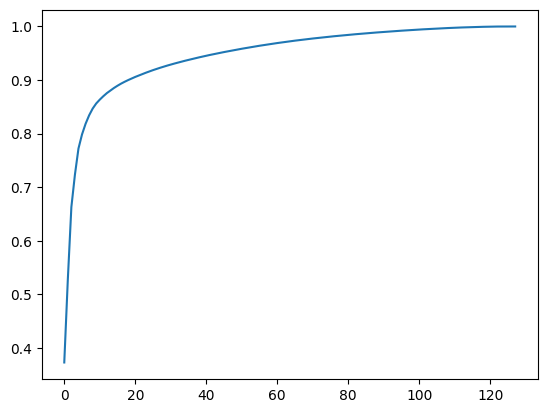

In [75]:
benchmark, rc = pca_auc(data)
print(benchmark)
plt.plot(rc)
plt.show()

In [77]:
pc_all_chanels = np.ndarray(128)
for c in range(len(channel_names)):
    dataaa = np.delete(data, c, axis=1)
    b, r = pca_auc(dataaa)
    pc_all_chanels[c] = b-benchmark

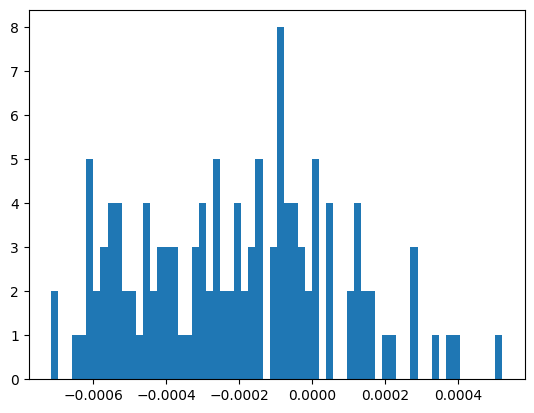

In [78]:
plt.hist(pc_all_chanels, bins=64)
plt.show()

In [79]:
order = np.argsort(pc_all_chanels)
print(channel_names[order])

['C15' 'C16' 'A27' 'B1' 'A26' 'A15' 'A24' 'B20' 'B8' 'A1' 'A14' 'A11'
 'A28' 'B31' 'B9' 'B30' 'D32' 'C8' 'C9' 'C14' 'C23' 'C22' 'B7' 'A25' 'C13'
 'A12' 'C18' 'D31' 'C27' 'B18' 'C30' 'A13' 'A23' 'C17' 'C19' 'C11' 'B22'
 'A16' 'A10' 'C10' 'C31' 'B32' 'A22' 'A29' 'C4' 'C26' 'D6' 'C3' 'B10'
 'C32' 'C2' 'D5' 'B19' 'B17' 'D30' 'D29' 'C28' 'C6' 'A17' 'B4' 'B5' 'B3'
 'B11' 'C20' 'A9' 'D9' 'D25' 'D19' 'B13' 'A30' 'B21' 'B12' 'C5' 'D8' 'D28'
 'B27' 'C24' 'C21' 'D24' 'D22' 'D4' 'D7' 'A21' 'B28' 'D10' 'C29' 'A8'
 'B15' 'D27' 'D13' 'B23' 'B2' 'D26' 'B16' 'B14' 'B24' 'A7' 'D3' 'B25'
 'C12' 'D21' 'A18' 'A32' 'A5' 'D18' 'C7' 'D12' 'D23' 'B26' 'A2' 'B6' 'D2'
 'D17' 'C25' 'A20' 'B29' 'D11' 'A31' 'A6' 'D16' 'A3' 'D14' 'A4' 'D20'
 'A19' 'D1' 'C1' 'D15']


In [80]:
bad_by_corr = np.where(pc_all_chanels > 0)[0]
print(channel_names[bad_by_corr])

['A2' 'A3' 'A4' 'A5' 'A6' 'A18' 'A19' 'A20' 'A31' 'A32' 'B6' 'B26' 'B29'
 'C1' 'C7' 'C25' 'D1' 'D2' 'D11' 'D12' 'D14' 'D15' 'D16' 'D17' 'D18' 'D20'
 'D21' 'D23']


In [81]:
idx = np.where((at_test1 < 0) & (test1 < 0) & (pc_all_chanels > 0))[0]
print(idx)

[ 57  60 106 116 118]


In [82]:
print(channel_names[idx])

['B26' 'B29' 'D11' 'D21' 'D23']


In [83]:
idx = np.where((at_test1 < 0) & (pc_all_chanels > 0))[0]
idx2 = np.where((test1 < 0) & (pc_all_chanels > 0))[0]
print(idx)
print(idx2)

[ 57  60 106 107 116 118]
[  1   2   3   4  18  57  60  64  70  88  96 106 110 112 115 116 118]


In [84]:
print(channel_names[idx])
print(channel_names[idx2])

['B26' 'B29' 'D11' 'D12' 'D21' 'D23']
['A2' 'A3' 'A4' 'A5' 'A19' 'B26' 'B29' 'C1' 'C7' 'C25' 'D1' 'D11' 'D15'
 'D17' 'D20' 'D21' 'D23']


In [85]:
acum = []
for cn in channel_names[np.argsort(test1)]:
    if cn in channel_names[bad_by_corr]:
        print(cn)
        acum.append(cn)
    else:
        break
for cn in channel_names[np.argsort(at_test1)]:
    if cn in channel_names[bad_by_corr]:
        if cn not in acum:
            print(cn)
    else:
        break

B26
